## whole brain GMs within NPC mask

* formally quantify `Less Integration in NPC` 
* visualization on brain surface, somehow gavce rise to support of `competing space for spatial-numerical vs. "social" cortical computation space in dyscalculia` hypothesis


In [9]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
from brainspace.gradient import GradientMaps
from utils import get_basic_mask
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 
plot_folder = op.join(bids_folder, 'plots_and_ims/gradient_stuff')
phenotype_folder = op.join(bids_folder, 'derivatives/phenotype')

from os import listdir
subList = [f[4:6] for f in listdir(op.join(bids_folder)) if f[0:4] == 'sub-' and len(f)==6]

fsaverage = fetch_surf_fsaverage('fsaverage5') 

# add group info
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list#.reset_index()



In [2]:
# get masks
surf_mask_L = op.join(bids_folder, 'derivatives/surface_masks', 'desc-NPC_L_space-fsaverage5_hemi-lh.label.gii')
surf_mask_L = nib.load(surf_mask_L).agg_data()
surf_mask_R = op.join(bids_folder, 'derivatives/surface_masks', 'desc-NPC_R_space-fsaverage5_hemi-rh.label.gii')
surf_mask_R = nib.load(surf_mask_R).agg_data()
nprf_r2 = np.concatenate((surf_mask_L, surf_mask_R))

mask, labeling_noParcel = get_basic_mask()
#nprf_r2_mask = np.bool_(nprf_r2[mask])
nprf_r2 = np.bool_(nprf_r2)

np.shape(nprf_r2)


(20484,)

In [3]:
## load in gradients

n_gradients = 5
gms_aligned = {f'g{i+1}': [] for i in range(n_gradients)}
for sub in subList:
    source_folder_gm = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
    gm_aligned = np.load(op.join(source_folder_gm,f'sub-{sub}_g-aligned_space-fsaverag5_n10.npy'))
    for i in range(n_gradients):
        gms_aligned[f'g{i+1}'].append(gm_aligned[i, :])

sub_array = np.array([int(i) for i in subList])
dfs = []
for i in range(n_gradients):
    gradient_df = pd.DataFrame(gms_aligned[f'g{i+1}'], index=sub_array)
    gradient_df.index.name = 'subject'
    gradient_df = gradient_df.join(group_list).set_index('group', append=True)
    gradient_df['n_gradient'] = i + 1
    dfs.append(gradient_df.set_index('n_gradient', append=True))

df_gms = pd.concat(dfs).sort_index(level='n_gradient')

In [4]:
# take NPC as a network and compute dispersion
n_grad = 2
g1 = np.array(gms_aligned[f'g{n_grad}']).T # n_vertices x n_subjects

# get the gradient loadings of the nodes of the ROI, for each subject (shape: number of nodes in network x N)
G1_net = g1[nprf_r2]

centroid_cog_net = np.nanmedian(G1_net, axis=0)  #np.median(G1_net, axis=0)  
dist_nodes_to_centroid = G1_net - centroid_cog_net  # shape: number of nodes in network x N

NPC_dispersion = np.nanmean((dist_nodes_to_centroid**2), axis = 0) 

In [ ]:
df = pd.DataFrame(np.array([NPC_dispersion, centroid_cog_net]).T, index=sub_array, columns=['NPC_dispersion', 'NPC_centroid'])
df.index.name = 'subject'
df = df.join(group_list).set_index('group',append=True)
# df.to_csv(op.join(phenotype_folder, f'withinNdispersion-NPC_grad-{n_grad}.csv'))
df.head()


,,NPC_dispersion,NPC_centroid
subject,group,,
21,0,11.874677,1.504974
59,0,2.687693,1.923676
54,0,6.611221,2.240979
15,0,15.730722,1.744303
52,0,3.709795,0.589167


/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


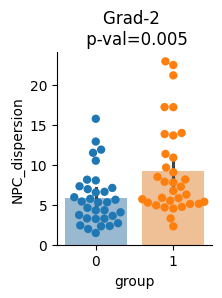

In [7]:
from scipy.stats import ttest_ind

y_var = 'NPC_dispersion' #  'NPC_centroid'

tmp = df.copy()

figure, axes = plt.subplots(1, 1,figsize = (2,2.5))
sns.barplot(data=tmp.reset_index(), x ='group', hue='group',y=y_var, alpha=0.5,legend=False)
sns.swarmplot(data=tmp.reset_index(),  x ='group', hue='group',y=y_var, size=6,legend=False)
t_stats, p_values = ttest_ind(tmp.xs(0,0,'group')[y_var], tmp.xs(1,0,'group')[y_var], axis=0, equal_var=False)
p_val = np.round(p_values,3)

axes.set(title=f'Grad-{n_grad} \n p-val={p_val}',ylabel=y_var, xlabel='group')
sns.despine()

/tmp/ipykernel_1864999/3046246177.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_ = np.round(cor['r'][0], 2)
/tmp/ipykernel_1864999/3046246177.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = np.round(cor['p-val'][0], 5)


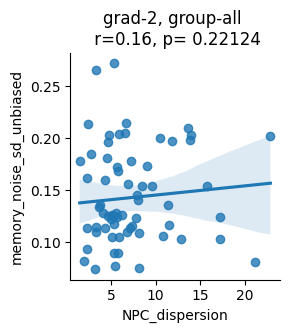

In [94]:
y_var = 'memory_noise_sd_unbiased' #'perceptual_noise_sd' # 'Percent Correct'# _unbiased 'memory_noise_sd_unbiased
group = 'all' # 1 # 

from utils_02 import get_all_behavior
df_behav = get_all_behavior(bids_folder)

import pingouin
tmp = df_comb.xs(group, level='group') if group != 'all' else df_comb.drop(46, level='subject') # sub-46 drives effect !
x_var = 'NPC_dispersion'
cor = pingouin.corr(tmp[y_var], tmp[x_var], method = 'shepherd') # shepherd,spearman,pearson || defautl: two -sided & pearson 
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)

fig = sns.lmplot(x=x_var, y=y_var, data=tmp,height=3, robust=True) #  hue='group',
fig.set(title=f'grad-{n_grad}, group-{group} \n r={r_}, p= {p}' ) 

# pearson got effect but only when sub-46 is included --> not robust to outliers

Text(0.5, 1.0, 'group average NPC-vertices')

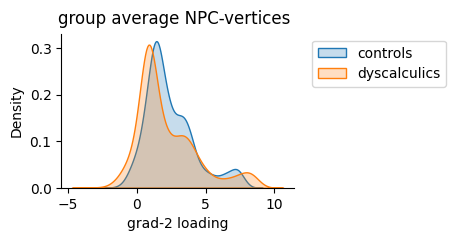

In [22]:
n_grad = 2
tmp = df_gms.iloc[:,nprf_r2].xs(n_grad, level='n_gradient')

fig, axes = plt.subplots(1, 1,figsize = (3,2))
sns.kdeplot(tmp.xs(0, level='group').mean(axis=0), label='controls',fill=True,ax=axes)
sns.kdeplot(tmp.xs(1, level='group').mean(axis=0), label='dyscalculics',ax=axes,fill=True)
sns.despine()
axes.set(xlabel=f'grad-{n_grad} loading')
axes.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle(f'group average NPC-vertices',y=1.)


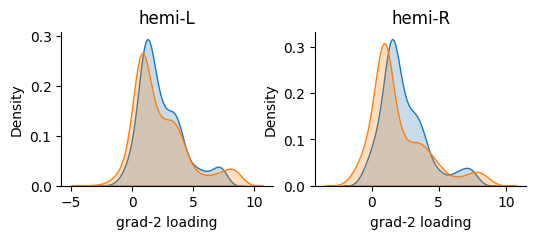

In [29]:
nprf_r2_R = np.bool_(np.concatenate((np.zeros(len(surf_mask_L)), surf_mask_R)))
nprf_r2_L = np.bool_(np.concatenate((surf_mask_L, np.zeros(len(surf_mask_R)))))

fig, axes = plt.subplots(1, 2,figsize = (6,2))

for hemi, mask,i in zip(['L','R'],[nprf_r2_L, nprf_r2_R], [0,1]):
    tmp = df_gms.iloc[:,mask].xs(n_grad, level='n_gradient')
    sns.kdeplot(tmp.xs(0, level='group').mean(axis=0), label='controls',fill=True,ax=axes[i])
    sns.kdeplot(tmp.xs(1, level='group').mean(axis=0), label='dyscalculics',ax=axes[i],fill=True)
    axes[i].set(xlabel=f'grad-{n_grad} loading',title=f'hemi-{hemi}')
sns.despine()


## Plot on surface

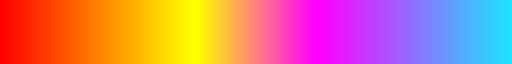

In [76]:
import matplotlib.colors as colors
N_colors = 256 # total number of colors in the colormap, actual number does not matter, just ratio
n_padding = 40
skewed = True
first = n_padding
middle = 256-n_padding*2
third = n_padding 

colors1 = plt.cm.autumn(np.linspace(0, 1, first))
colors2 = plt.cm.spring(np.linspace(0, 1, second))[::-1]
colors3 = plt.cm.cool(np.linspace(0.1,1 , first))[::-1] # .98

# combine them and build a new colormap
cols = np.vstack((colors1,colors2,colors3)) # for reverestion add [::-1]
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols )
mymap

# best cmap-params for visualization of
#  >competing space for spatial-numerical vs. "social" cortical computation space in dyscalculia< hypothesis
# n_padding = 40 (for 256 =N_colors); cols (not reversed!) = autumn, spring.reverse, cool.reverse;

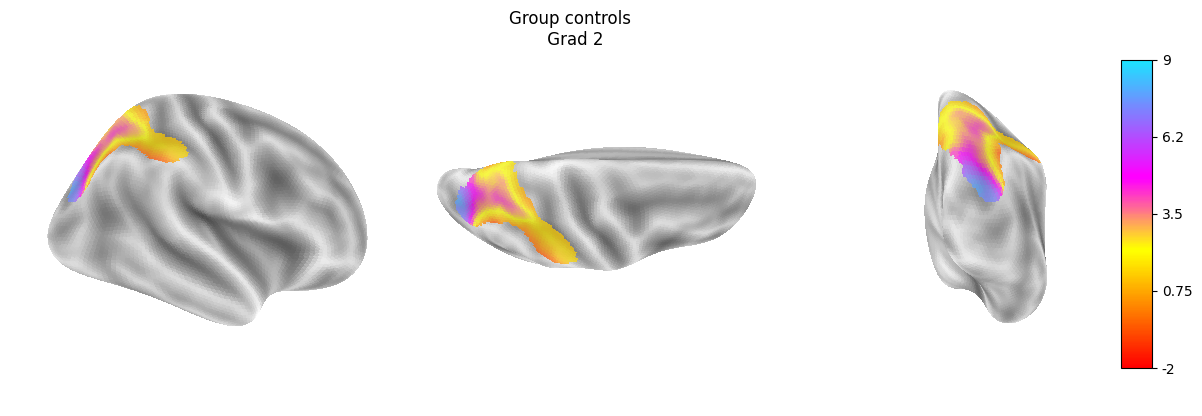

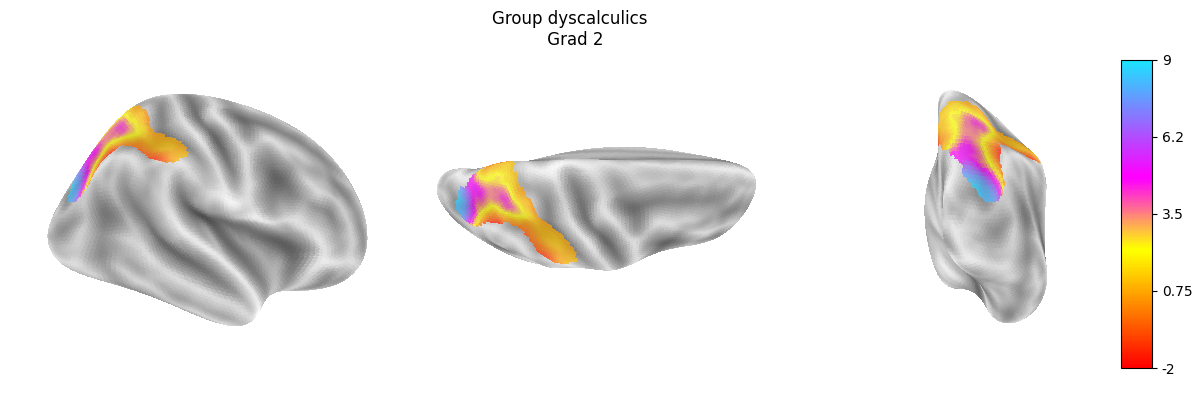

In [100]:
# plot the gradient on the surface
mask, labeling_noParcel = get_basic_mask()
hemi = 'R'
views = ['medial','dorsal','posterior']
#n_components = 4

n_grad = 2
tmp = df_gms.iloc[:,nprf_r2].xs(n_grad, level='n_gradient')

for group,group_name in zip(range(2), ['controls', 'dyscalculics']):
    map = np.full(np.shape(mask), np.nan)#  np.zeros(np.shape(mask)) # 
    map[nprf_r2] = tmp.xs(group, level='group').mean(axis=0)
    gms = np.split(map,2) # for i, hemi in enumerate(['L', 'R']): --> left first
    gm_hemi = gms[1]# right    
    
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left

    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (15,8), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= gm_hemi, vmin=-2, vmax=9,
                view= view,cmap=mymap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[i]) 
        
    #axes[2].set(ylim=[-100, 20],)
    figure.suptitle(f'Group {group_name} \n Grad {n_grad}', y=0.75)
    figure.subplots_adjust(wspace=0.01)

## Plot in coordinate space

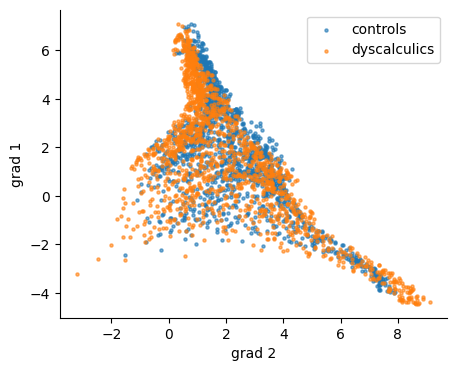

In [99]:
fig, ax = plt.subplots(figsize=(5,4))
group = 0
tmp_1 = df_gms.iloc[:,nprf_r2].xs(1, level='n_gradient').xs(group, level='group').mean(axis=0)
tmp_2 = df_gms.iloc[:,nprf_r2].xs(2, level='n_gradient').xs(group, level='group').mean(axis=0)
ax.scatter(tmp_2,tmp_1,s=5,alpha=0.6)   
group = 1
tmp_1 = df_gms.iloc[:,nprf_r2].xs(1, level='n_gradient').xs(group, level='group').mean(axis=0)
tmp_2 = df_gms.iloc[:,nprf_r2].xs(2, level='n_gradient').xs(group, level='group').mean(axis=0)
ax.scatter(tmp_2,tmp_1,s=5,alpha=0.6)   
ax.set(xlabel='grad 2', ylabel='grad 1')
ax.legend(['controls','dyscalculics'])
sns.despine()


# Correlate with other Network measures 


In [26]:
betweenN = pd.read_csv(op.join(phenotype_folder,f'betweenNdispersion_grad-{n_grad}.csv'))
withinN = pd.read_csv(op.join(phenotype_folder,f'withinNdispersion_grad-{n_grad}.csv'))

withinN_NPC = pd.read_csv(op.join(phenotype_folder,f'withinNdispersion-NPC_grad-{n_grad}.csv'))

In [28]:
df_comb = withinN_NPC.set_index(['subject','group']).join(withinN.set_index(['subject'])).join(betweenN.set_index(['subject','group']))#.reset_index()
df_comb  

,,NPC_dispersion,NPC_centroid,Visual1,Visual2,Somatomotor,Cingulo-Opercular,Dorsal-attention,Language,Frontoparietal,Auditory,...,Auditory - Default,Auditory - Posterior-Multimodal,Auditory - Ventral-Multimodal,Auditory - Orbito-Affective,Default - Posterior-Multimodal,Default - Ventral-Multimodal,Default - Orbito-Affective,Posterior-Multimodal - Ventral-Multimodal,Posterior-Multimodal - Orbito-Affective,Ventral-Multimodal - Orbito-Affective
subject,group,,,,,,,,,,,,,,,,,,,,,
21,0,11.874677,1.504974,10.153303,7.447543,0.447357,2.318246,10.196372,3.833786,4.340712,0.334249,...,3.382879,1.800409,2.367144,2.469386,5.183288,1.015734,0.913492,4.167554,4.269795,0.102242
59,0,2.687693,1.923676,4.858531,9.504181,1.615940,6.681286,11.832134,29.381217,33.073216,7.357532,...,3.683830,0.815217,16.316776,12.180263,4.499047,12.632946,8.496434,17.131993,12.995481,4.136513
54,0,6.611221,2.240979,9.705321,11.298490,1.447574,3.905404,7.972687,12.785947,14.621594,2.159586,...,7.334048,0.314088,11.570558,8.286899,7.019960,4.236510,0.952851,11.256470,7.972812,3.283659
15,0,15.730722,1.744303,15.263112,7.208842,0.498589,5.591301,9.741935,9.886217,6.609338,0.594399,...,6.838587,1.294221,2.482825,5.276526,8.132808,4.355763,1.562062,3.777046,6.570746,2.793701
52,0,3.709795,0.589167,5.280768,4.619278,0.201913,0.696613,2.176468,2.892484,3.318138,0.237398,...,2.302187,0.390150,3.817462,2.448269,2.692337,1.515275,0.146082,4.207612,2.838419,1.369193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,0,2.298682,1.679807,4.481891,5.157240,0.469556,1.930742,4.662209,8.371114,6.191998,1.743734,...,3.030988,0.174881,8.403972,5.304284,3.205869,5.372984,2.273296,8.578853,5.479165,3.099688
42,1,8.147018,2.435612,13.869658,7.608506,1.051228,7.543673,10.412096,16.345878,11.688378,0.971728,...,9.387574,0.783343,5.059017,6.255169,8.604231,4.328557,3.132406,4.275674,5.471825,1.196151
25,1,6.262626,0.965342,3.471827,7.163409,1.173535,2.966603,6.926468,8.043301,6.347345,3.787230,...,4.973056,1.156075,7.225136,5.169299,6.129130,2.252080,0.196243,8.381210,6.325373,2.055837


In [34]:
betweenN.columns

Index(['subject', 'group', 'Visual1 - Visual2', 'Visual1 - Somatomotor',
       'Visual1 - Cingulo-Opercular', 'Visual1 - Dorsal-attention',
       'Visual1 - Language', 'Visual1 - Frontoparietal', 'Visual1 - Auditory',
       'Visual1 - Default', 'Visual1 - Posterior-Multimodal',
       'Visual1 - Ventral-Multimodal', 'Visual1 - Orbito-Affective',
       'Visual2 - Somatomotor', 'Visual2 - Cingulo-Opercular',
       'Visual2 - Dorsal-attention', 'Visual2 - Language',
       'Visual2 - Frontoparietal', 'Visual2 - Auditory', 'Visual2 - Default',
       'Visual2 - Posterior-Multimodal', 'Visual2 - Ventral-Multimodal',
       'Visual2 - Orbito-Affective', 'Somatomotor - Cingulo-Opercular',
       'Somatomotor - Dorsal-attention', 'Somatomotor - Language',
       'Somatomotor - Frontoparietal', 'Somatomotor - Auditory',
       'Somatomotor - Default', 'Somatomotor - Posterior-Multimodal',
       'Somatomotor - Ventral-Multimodal', 'Somatomotor - Orbito-Affective',
       'Cingulo-Opercular

/tmp/ipykernel_3777717/1979423453.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_ = np.round(cor['r'][0], 2)
/tmp/ipykernel_3777717/1979423453.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = np.round(cor['p-val'][0], 5)


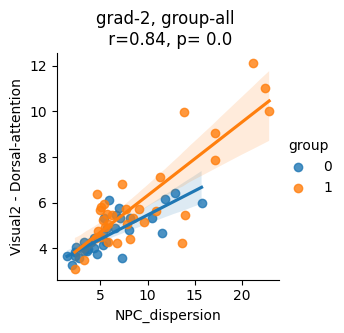

In [47]:
y_var = 'Visual2 - Dorsal-attention' #Visual2 - Dorsal-attention' # 'Visual2' # 'Visual2 - Cingulo-Opercular' 
x_var = 'NPC_dispersion'

group = 'all' # 1 # 

import pingouin
tmp = df_comb.xs(group, level='group') if group != 'all' else df_comb#.drop(46, level='subject') # sub-46 drives effect !

cor = pingouin.corr(tmp[y_var], tmp[x_var], method = 'pearson') # shepherd,spearman,pearson || defautl: two -sided & pearson 
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)

fig = sns.lmplot(x=x_var, y=y_var, data=tmp.reset_index(),height=3, robust=True, hue='group') #  hue='group',
fig.set(title=f'grad-{n_grad}, group-{group} \n r={r_}, p= {p}' ) 

# pearson got effect but only when sub-46 is included --> not robust to outliers

In [48]:
df_comb.sort_values(by='NPC_dispersion',ascending=False).head(10)

,,NPC_dispersion,NPC_centroid,Visual1,Visual2,Somatomotor,Cingulo-Opercular,Dorsal-attention,Language,Frontoparietal,Auditory,...,Auditory - Default,Auditory - Posterior-Multimodal,Auditory - Ventral-Multimodal,Auditory - Orbito-Affective,Default - Posterior-Multimodal,Default - Ventral-Multimodal,Default - Orbito-Affective,Posterior-Multimodal - Ventral-Multimodal,Posterior-Multimodal - Orbito-Affective,Ventral-Multimodal - Orbito-Affective
subject,group,,,,,,,,,,,,,,,,,,,,,
40,1,22.897534,0.772252,14.757765,23.256091,1.508023,1.388839,16.822321,5.392294,8.390026,0.364289,...,4.900035,0.880804,5.717793,4.092774,5.780839,0.817758,0.807260,6.598597,4.973579,1.625019
46,1,22.442648,-0.223817,14.674391,23.106934,1.067978,3.406809,12.212064,6.171037,4.979412,0.706481,...,5.631968,0.001083,4.730986,3.129495,5.633051,0.900982,2.502472,4.732069,3.130579,1.601490
39,1,21.148244,0.720437,8.815854,22.552953,0.912941,4.740928,13.541396,9.983636,9.343958,1.960503,...,8.869656,1.312179,6.217780,6.947912,7.557477,2.651877,1.921744,4.905600,5.635733,0.730132
27,1,17.190192,0.668134,11.862398,16.341040,0.751342,2.447229,11.498605,7.382243,6.677522,0.616593,...,6.395927,0.422924,7.607007,5.423459,5.973003,1.211080,0.972468,7.184084,5.000535,2.183548
50,1,17.181186,1.040090,9.776198,12.063222,0.978967,4.214272,11.917817,17.790325,9.904165,0.882972,...,7.361355,0.156799,4.290612,3.284950,7.204556,3.070743,4.076405,4.133813,3.128151,1.005662
15,0,15.730722,1.744303,15.263112,7.208842,0.498589,5.591301,9.741935,9.886217,6.609338,0.594399,...,6.838587,1.294221,2.482825,5.276526,8.132808,4.355763,1.562062,3.777046,6.570746,2.793701
33,1,13.956580,2.965117,10.801241,9.035050,1.730280,6.315085,13.317733,12.439491,10.331228,1.198570,...,8.299290,0.182330,3.871586,4.936628,8.116960,4.427704,3.362662,3.689256,4.754298,1.065042
43,1,13.818312,1.227525,31.384558,31.400511,1.077813,4.160413,11.670402,6.050477,6.330776,2.819832,...,4.716718,0.595926,2.390266,3.209988,5.312644,2.326452,1.506730,2.986191,3.805914,0.819722
22,1,13.645429,4.614779,13.390191,9.331021,3.777634,5.205859,14.328990,10.282061,9.188372,0.580409,...,5.053108,2.540184,4.016515,3.243427,7.593292,1.036593,1.809681,6.556698,5.783611,0.773088
